## In this notebook, we will try to implement a Convolutional Neural network only using 'Numpy'...

In [1]:
# This is what we need...

import sys

# For some data...
import skimage.data

# For Visualization...
import matplotlib.pyplot as plt
%matplotlib inline

# For everything else...
import numpy as np

In [2]:
# ----------------------------------------------------------------------------------

In [3]:
# ********** CONVOLUTION LAYER **********

'''
    The convolution is applied by a function called conv_
    which is different from the conv function.
    The function conv just accepts the input image and the filter bank
    but doesn’t apply convolution its own. 
    It just passes each set of input-filter pairs to be convolved to the conv_ function.
    This is just for making the code simpler to investigate.
'''

def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = np.zeros((img.shape))
    
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        
        for c in np.uint16(np.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            curr_region = img[r - np.uint16(np.floor(filter_size/2.0)):r + np.uint16(np.ceil(filter_size/2.0)), 
                              c - np.uint16(np.floor(filter_size/2.0)):c + np.uint16(np.ceil(filter_size/2.0))]
            
            # Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            
            # Summing the result of multiplication.
            conv_sum = np.sum(curr_result) 
            
            # Saving the summation in the convolution layer feature map.
            result[r, c] = conv_sum 
            
    # Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2.0):result.shape[0] - np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1] - np.uint16(filter_size/2.0)]
    
    return final_result


# conv() accepts just two arguments which are the image and the filter bank

def conv(img, conv_filter):
    # Check if number of image channels matches the filter depth.
    if len(img.shape) > 2 or len(conv_filter.shape) > 3:
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    
    # Check if filter dimensions are equal.        
    if conv_filter.shape[1] != conv_filter.shape[2]:
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
        
    # Check if filter diemnsions are odd.
    if conv_filter.shape[1]%2==0:
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        print("Filter ", filter_num + 1)
        # getting a filter from the bank.
        curr_filter = conv_filter[filter_num, :] 
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        
        if len(curr_filter.shape) > 2:
            # Array holding the sum of all feature maps.
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0])
            
            # Convolving each channel with the image and summing the results.
            for ch_num in range(1, curr_filter.shape[-1]): 
                conv_map = conv_map + conv_(img[:, :, ch_num], curr_filter[:, :, ch_num])
        
        else:
            # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        
        # Holding feature map with the current filter.
        feature_maps[:, :, filter_num] = conv_map 
    
    # Return all feature maps.
    return feature_maps


In [4]:
# ----------------------------------------------------------------------------------

In [5]:
# ********** ReLU LAYER **********

# The ReLU layer applies the ReLU activation
# function over each feature map returned by the conv layer.

def relu(feature_map):
    #Preparing the output of the ReLU activation function.
    relu_out = np.zeros(feature_map.shape)
    
    for map_num in range(feature_map.shape[-1]):
    
        for r in np.arange(0,feature_map.shape[0]):
    
            for c in np.arange(0, feature_map.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_map[r, c, map_num], 0])
    
    return relu_out

In [6]:
# ----------------------------------------------------------------------------------

In [7]:
# ********** MAX-POOLING LAYER **********

# The max pooling layer accepts the output of the ReLU layer
# and applies the max pooling operation...

# Here, size = dimentions of square filter and
#       strides = sliding rate of the filter...

def pooling(feature_map, size, strides):
    #Preparing the output of the pooling operation.
    pool_out = np.zeros((np.uint16((feature_map.shape[0] - size + 1)/strides),
                            np.uint16((feature_map.shape[1] - size + 1)/strides),
                            feature_map.shape[-1]))
    
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
    
        for r in np.arange(0, feature_map.shape[0] - size - 1, strides):
            c2 = 0
            
            for c in np.arange(0, feature_map.shape[1] - size - 1, strides):
                pool_out[r2, c2, map_num] = np.max([feature_map[r:r + size,  c:c + size, map_num]])
                c2 = c2 + 1
            
            r2 = r2 +1
    
    return pool_out

In [8]:
# ----------------------------------------------------------------------------------

In [9]:
# At this point, we have implemented the basic architecture of CNN.
# Now let's see if if it works on our data...

In [10]:
# 1. Reading the image
img = skimage.data.chelsea()

# Converting the image into gray.
img = skimage.color.rgb2gray(img)

In [11]:
# Prepare the filters bank for
# the first conv layer (l1 for short):

l1_filter = np.zeros((2,3,3)) # (2=num_filters, 3=num_rows_filter, 3=num_columns_filter)

print(l1_filter)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [12]:
'''
    The size of the filters bank is specified by the above
    zero array but not the actual values of the filters.
    It is possible to override such values as
    follows to detect 'vertical' and 'horizontal' edges.
'''

l1_filter[0, :, :] = np.array([[[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]]
                                 ])

l1_filter[1, :, :] = np.array([[[1,   1,  1],
                                   [0,   0,  0],
                                   [-1, -1, -1]]
                                 ])

In [13]:
# Implementing the Architecture...
print('LAYER_1')
# Working with conv layer 1...
l1_feature_map = conv(img, l1_filter)

# Applying ReLU Activation...
l1_feature_map_relu = relu(l1_feature_map)

# Max-Pooling...
l1_feature_map_relu_pool = pooling(l1_feature_map_relu, 2, 2)


print('\nLAYER_2')
# Working with conv layer 2...
l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_pool.shape[-1])

l2_feature_map = conv(l1_feature_map_relu_pool, l2_filter)

# Applying ReLU Activation...
l2_feature_map_relu = relu(l2_feature_map)

# Max-Pooling...
l2_feature_map_relu_pool = pooling(l2_feature_map_relu, 2, 2)

print('\nLAYER_3')
# Working with conv layer 3...
l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_pool.shape[-1])

l3_feature_map = conv(l2_feature_map_relu_pool, l3_filter)

# Applying ReLU Activation...
l3_feature_map_relu = relu(l3_feature_map)

# Max-Pooling...
l3_feature_map_relu_pool = pooling(l3_feature_map_relu, 2, 2)


LAYER_1
Filter  1
Filter  2

LAYER_2
Filter  1
Filter  2
Filter  3

LAYER_3
Filter  1


### Results of above iteration...

[]

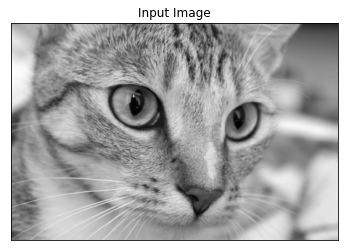

In [14]:
fig0, ax0 = plt.subplots(nrows = 1, ncols = 1)

ax0.imshow(img).set_cmap("gray")
ax0.set_title("Input Image")
ax0.get_xaxis().set_ticks([])
ax0.get_yaxis().set_ticks([])

Text(0.5, 1.0, 'L1-Map2ReLUPool')

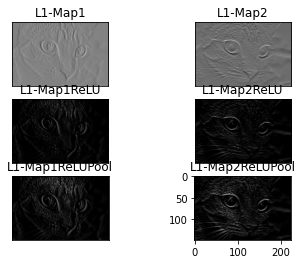

In [15]:
fig1, ax1 = plt.subplots(nrows = 3, ncols = 2)
ax1[0, 0].imshow(l1_feature_map[:, :, 0]).set_cmap("gray")
ax1[0, 0].get_xaxis().set_ticks([])
ax1[0, 0].get_yaxis().set_ticks([])
ax1[0, 0].set_title("L1-Map1")

ax1[0, 1].imshow(l1_feature_map[:, :, 1]).set_cmap("gray")
ax1[0, 1].get_xaxis().set_ticks([])
ax1[0, 1].get_yaxis().set_ticks([])
ax1[0, 1].set_title("L1-Map2")

ax1[1, 0].imshow(l1_feature_map_relu[:, :, 0]).set_cmap("gray")
ax1[1, 0].get_xaxis().set_ticks([])
ax1[1, 0].get_yaxis().set_ticks([])
ax1[1, 0].set_title("L1-Map1ReLU")

ax1[1, 1].imshow(l1_feature_map_relu[:, :, 1]).set_cmap("gray")
ax1[1, 1].get_xaxis().set_ticks([])
ax1[1, 1].get_yaxis().set_ticks([])
ax1[1, 1].set_title("L1-Map2ReLU")

ax1[2, 0].imshow(l1_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 0].set_title("L1-Map1ReLUPool")

ax1[2, 1].imshow(l1_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax1[2, 0].get_xaxis().set_ticks([])
ax1[2, 0].get_yaxis().set_ticks([])
ax1[2, 1].set_title("L1-Map2ReLUPool")

Text(0.5, 1.0, 'L2-Map3ReLUPool')

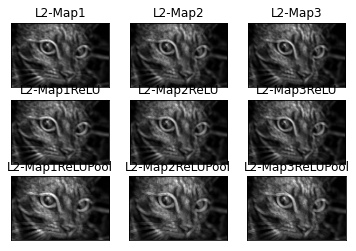

In [16]:
fig2, ax2 = plt.subplots(nrows = 3, ncols = 3)
ax2[0, 0].imshow(l2_feature_map[:, :, 0]).set_cmap("gray")
ax2[0, 0].get_xaxis().set_ticks([])
ax2[0, 0].get_yaxis().set_ticks([])
ax2[0, 0].set_title("L2-Map1")

ax2[0, 1].imshow(l2_feature_map[:, :, 1]).set_cmap("gray")
ax2[0, 1].get_xaxis().set_ticks([])
ax2[0, 1].get_yaxis().set_ticks([])
ax2[0, 1].set_title("L2-Map2")

ax2[0, 2].imshow(l2_feature_map[:, :, 2]).set_cmap("gray")
ax2[0, 2].get_xaxis().set_ticks([])
ax2[0, 2].get_yaxis().set_ticks([])
ax2[0, 2].set_title("L2-Map3")

ax2[1, 0].imshow(l2_feature_map_relu[:, :, 0]).set_cmap("gray")
ax2[1, 0].get_xaxis().set_ticks([])
ax2[1, 0].get_yaxis().set_ticks([])
ax2[1, 0].set_title("L2-Map1ReLU")

ax2[1, 1].imshow(l2_feature_map_relu[:, :, 1]).set_cmap("gray")
ax2[1, 1].get_xaxis().set_ticks([])
ax2[1, 1].get_yaxis().set_ticks([])
ax2[1, 1].set_title("L2-Map2ReLU")

ax2[1, 2].imshow(l2_feature_map_relu[:, :, 2]).set_cmap("gray")
ax2[1, 2].get_xaxis().set_ticks([])
ax2[1, 2].get_yaxis().set_ticks([])
ax2[1, 2].set_title("L2-Map3ReLU")

ax2[2, 0].imshow(l2_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax2[2, 0].get_xaxis().set_ticks([])
ax2[2, 0].get_yaxis().set_ticks([])
ax2[2, 0].set_title("L2-Map1ReLUPool")

ax2[2, 1].imshow(l2_feature_map_relu_pool[:, :, 1]).set_cmap("gray")
ax2[2, 1].get_xaxis().set_ticks([])
ax2[2, 1].get_yaxis().set_ticks([])
ax2[2, 1].set_title("L2-Map2ReLUPool")

ax2[2, 2].imshow(l2_feature_map_relu_pool[:, :, 2]).set_cmap("gray")
ax2[2, 2].get_xaxis().set_ticks([])
ax2[2, 2].get_yaxis().set_ticks([])
ax2[2, 2].set_title("L2-Map3ReLUPool")

Text(0.5, 1.0, 'L3-Map1ReLUPool')

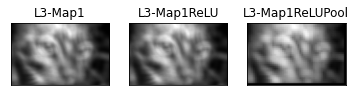

In [17]:
fig3, ax3 = plt.subplots(nrows = 1, ncols = 3)

ax3[0].imshow(l3_feature_map[:, :, 0]).set_cmap("gray")
ax3[0].get_xaxis().set_ticks([])
ax3[0].get_yaxis().set_ticks([])
ax3[0].set_title("L3-Map1")

ax3[1].imshow(l3_feature_map_relu[:, :, 0]).set_cmap("gray")
ax3[1].get_xaxis().set_ticks([])
ax3[1].get_yaxis().set_ticks([])
ax3[1].set_title("L3-Map1ReLU")

ax3[2].imshow(l3_feature_map_relu_pool[:, :, 0]).set_cmap("gray")
ax3[2].get_xaxis().set_ticks([])
ax3[2].get_yaxis().set_ticks([])
ax3[2].set_title("L3-Map1ReLUPool")

In [18]:
# That's it! Our CNN works...